In [ ]:
# default_exp mli


# SHAP



In [ ]:
#hide
%load_ext autoreload
%autoreload 2
from nbdev.showdoc import *

In [ ]:
%matplotlib inline

In [ ]:
import lightgbm as lgb
lgb.__version__

'3.1.1'

In [ ]:
import plotly
plotly.__version__

'4.14.3'

In [ ]:
import shap
shap.initjs()
shap.__version__

'0.38.1'

In [ ]:
# export
import numpy as np


def logit(p):
    """ Compute log-odds of p """
    assert 0 < p < 1
    return log(p / 1 - p)


def expit(a):
    """ The reverse of logit """
    p = 1 / (1 + np.exp(-a))
    assert 0 < p < 1
    return p

In [ ]:
# export
from fastcore.basics import store_attr
import shap


class Shap:
    """ Fit a model for X, y, then explain it using SHAP plots """

    def __init__(self, X, y, model, n_samples=1000):
        store_attr()

        model.fit(X, y)

        self.samples = samples = X.iloc[:n_samples]
        self.explainer = shap.Explainer(model, samples)
        self.shap_values = self.explainer(samples)

    def force_plot(self, n_plots=1):
        """ Display a SHAP force plot """
        plot = shap.force_plot(
            self.explainer.expected_value,
            self.shap_values.values[:n_plots],
            self.samples.iloc[:n_plots],
            link="logit",
        )
        return plot

    def waterfall_plot(self, id: int):
        """ Display SHAP waterfall plot """
        plot = shap.plots.waterfall(self.shap_values[id])
        return plot

    def bar_plot(self, id: int, figsize=None):
        """ Display shap values in a bar plot """
        import pandas as pd

        df = pd.DataFrame(
            dict(
                shap=self.shap_values[id].values,
                shap_abs=abs(self.shap_values[id].values),
            ),
            index=[
                f"{v} = {n}" for n, v in zip(self.X.columns, self.shap_values[id].data)
            ],
        )
        plot = df.sort_values("shap_abs", ascending=False).plot.bar(y="shap", figsize=figsize)
        return plot


In [ ]:
X, y = shap.datasets.adult()
print(y)
X

[False False False ... False False  True]


Age  Workclass  Education-Num  Marital Status  Occupation  \
0      39.0          7           13.0               4           1   
1      50.0          6           13.0               2           4   
2      38.0          4            9.0               0           6   
3      53.0          4            7.0               2           6   
4      28.0          4           13.0               2          10   
...     ...        ...            ...             ...         ...   
32556  27.0          4           12.0               2          13   
32557  40.0          4            9.0               2           7   
32558  58.0          4            9.0               6           1   
32559  22.0          4            9.0               4           1   
32560  52.0          5            9.0               2           4   

       Relationship  Race  Sex  Capital Gain  Capital Loss  Hours per week  \
0                 0     4    1        2174.0           0.0            40.0   
1                 4     4    1           0.0           0.0            13.0   
2                 0     4    1           0.0           0.0            40.0   
3                 4     2    1           0.0           0.0            40.0   
4                 5     2    0           0.0           0.0            40.0   
...             ...   ...  ...           ...           ...             ...   
32556             5     4    0           0.0           0.0            38.0   
32557             4     4    1           0.0           0.0            40.0   
32558             1     4    0           0.0           0.0            40.0   
32559             3     4    1           0.0           0.0            20.0   
32560             5     4    0       15024.0           0.0            40.0   

       Country  
0           39  
1           39  
2           39  
3           39  
4            5  
...        ...  
32556       39  
32557       39  
32558       39  
32559       39  
32560       39  

[32561 rows x 12 columns]

In [ ]:
from lightgbm.sklearn import LGBMClassifier
model = LGBMClassifier()

In [ ]:
sh = Shap(X, y, model)

In [ ]:
show_doc(Shap.waterfall_plot)

<h4 id="Shap.waterfall_plot" class="doc_header"><code>Shap.waterfall_plot</code><a href="__main__.py#L28" class="source_link" style="float:right">[source]</a></h4>

> <code>Shap.waterfall_plot</code>(**`id`**:`int`)

Display SHAP waterfall plot 

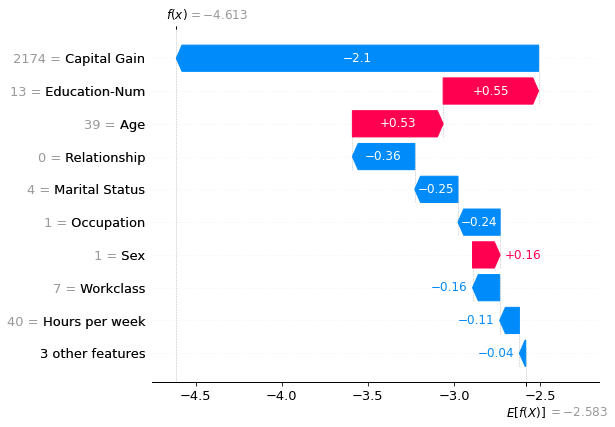

In [ ]:
sh.waterfall_plot(id=0)

In [ ]:
import plotly.io as pio
print(pio.renderers.default)

plotly_mimetype+notebook


In [ ]:
# export
from fastcore.foundation import patch


@patch
def wf_plot(self: Shap, id: int, 
            title="",
            n_feature=0, n_pos=0, n_neg=0,
           ):
    """ Display shap values in a waterfall plot.
    
    Params:
    
        - n_feature: Number of features with larger SHAP values to show in the plot.
        - n_pos: Number of features with positive SHAP values to show in the plot.
        - n_neg: Number of features with negative SHAP values to show in the plot.
    """
    import pandas as pd
    import plotly.graph_objects as go

    df = pd.DataFrame(
        dict(
            data=self.shap_values[id].data,
            feature_val=[
                f"{v} = {n}" for n, v in zip(self.X.columns, self.shap_values[id].data)
            ],
            shap=self.shap_values[id].values,
            shap_abs=abs(self.shap_values[id].values),
            shap_positive=(self.shap_values[id].values > 0),
        ),
        index=self.X.columns,
    )
    df = df[df.shap != 0]
    df = df.sort_values("shap_abs", ascending=False)

    if 0 < n_feature < df.shape[0]:
        others = df.iloc[n_feature:].shap.sum()
        df = df.iloc[:n_feature].append(
            dict(
                feature_val="Others",
                shap=others,
                shap_abs=abs(others),
                shap_positive=(others > 0),
            ),
            ignore_index=True,
        )
    else:
        df_pos = df[df.shap_positive].sort_values("shap_abs", ascending=False)
        if n_pos > 0:
            if n_pos < df_pos.shape[0] - 1:
                p_others = df_pos.iloc[n_pos:].shap.sum()
                df_pos = df_pos.iloc[:n_pos].append(
                    dict(
                        feature_val="Others+",
                        shap=p_others,
                        shap_abs=abs(p_others),
                        shap_positive=(p_others > 0),
                    ),
                    ignore_index=True,
                )
        df_neg = df[~df.shap_positive].sort_values("shap_abs", ascending=False)
        if n_neg > 0:
            if n_neg < df_neg.shape[0] - 1:
                n_others = df_neg.iloc[n_neg:].shap.sum()
                df_neg = df_neg.iloc[:n_neg].append(
                    dict(
                        feature_val="Others-",
                        shap=n_others,
                        shap_abs=abs(n_others),
                        shap_positive=(n_others > 0),
                    ),
                    ignore_index=True,
                )
        df = df_pos.append(df_neg)
 
#     df = df.sort_values("shap_abs", ascending=False)
    df = df.sort_values("shap", ascending=False)

    fig = go.Figure(
        go.Waterfall(
#             name="インパクト",
            orientation="v",
            #         measure = ["relative", "total"],
            #         x = [ df.data, df.feature ],
            #         x = [ df.feature, df.data ],
            #         x = df.feature,
            x=df.feature_val,
            textposition="outside",
            y=df.shap,
            connector={"line": {"color": "green", "width": 1}},
            decreasing={"marker": {"color": "indianred"}},
            increasing={"marker": {"color": "deepskyblue"}},
        )
    )

    fig.update_layout(
        title=title,
#         showlegend=True,
    )
    fig.update_yaxes(
        #         visible=False,
        showticklabels=False,
        #         nticks=5,
        #         tick0=0.25,
        dtick=0.5,
    )
    return fig

In [ ]:
show_doc(Shap.wf_plot)

<h4 id="Shap.wf_plot" class="doc_header"><code>Shap.wf_plot</code><a href="__main__.py#L5" class="source_link" style="float:right">[source]</a></h4>

> <code>Shap.wf_plot</code>(**`id`**:`int`, **`title`**=*`''`*, **`n_feature`**=*`0`*, **`n_pos`**=*`0`*, **`n_neg`**=*`0`*)

Display shap values in a waterfall plot.

Params:

    - n_feature: Number of features with larger SHAP values to show in the plot.
    - n_pos: Number of features with positive SHAP values to show in the plot.
    - n_neg: Number of features with negative SHAP values to show in the plot.

In [ ]:
sh.wf_plot(3)

In [ ]:
sh.wf_plot(3, n_pos=3, n_neg=3, title="Features' impact")

In [ ]:
sh.wf_plot(3, n_feature=8, n_pos=3, n_neg=3)

In [ ]:
show_doc(Shap.bar_plot)

<h4 id="Shap.bar_plot" class="doc_header"><code>Shap.bar_plot</code><a href="__main__.py#L33" class="source_link" style="float:right">[source]</a></h4>

> <code>Shap.bar_plot</code>(**`id`**:`int`, **`figsize`**=*`None`*)

Display shap values in a bar plot 

<AxesSubplot:>

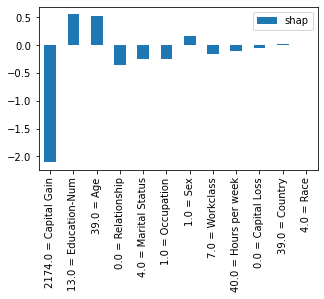

In [ ]:
sh.bar_plot(id=0, figsize=(5,3))

In [ ]:
show_doc(Shap.force_plot)

<h4 id="Shap.force_plot" class="doc_header"><code>Shap.force_plot</code><a href="__main__.py#L18" class="source_link" style="float:right">[source]</a></h4>

> <code>Shap.force_plot</code>(**`n_plots`**=*`1`*)

Display a SHAP force plot 

In [ ]:
sh.force_plot()

In [ ]:
sh.force_plot(1000)

In [ ]:
# hide
from nbdev.export import notebook2script
notebook2script()

Converted 00_core.ipynb.
Converted 01_shap.ipynb.
Converted 02_jpinfo.ipynb.
Converted 03_python-call-julia.ipynb.
Converted index.ipynb.
